In [547]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn import metrics
import pandas_datareader.data as web
from time import time

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')


## Data Preparation

#### (a) Get Data

In [548]:
# Read stock data use pandas_datareader.data from web
# Get Stock Data
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']
stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

In [549]:
# Select columns
base = stk_data.loc[:, ('Adj Close', 'MSFT')]
X1 = stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]
X2 = ccy_data
X3 = idx_data

#### (b) Standardized Data

In [550]:
# Standardized data (X1, X2, X3) with kept index (date)
standard_scaler = StandardScaler()
X1 = pd.DataFrame(standard_scaler.fit_transform(X1.values), index=X1.index, columns = X1.columns)
X2 = pd.DataFrame(standard_scaler.fit_transform(X2.values), index=X2.index, columns = X2.columns)
X3 = pd.DataFrame(standard_scaler.fit_transform(X3.values), index=X3.index, columns = X3.columns)

In [551]:
# Calculate ความแตกต่างของค่า ราคา 'Adj Close', 'MSFT’) ย้อนหลัง backHisotry วัน

backHistory = [30, 45, 60, 90, 180, 240]
BH1, BH2, BH3 = backHistory[1], backHistory[3], backHistory[4]
return_period = 2
Y = base.shift(-return_period)
X4_BH1 = base.diff( BH1).shift( - BH1)
X4_BH2 = base.diff( BH2).shift( - BH2)
X4_BH3 = base.diff( BH3).shift( - BH3)
X4 = pd.concat([X4_BH1, X4_BH2, X4_BH3], axis=1)
X4.columns = ['MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']
X4 = pd.DataFrame(standard_scaler.fit_transform(X4.values), index = X4.index,columns=X4.columns)

In [552]:
# Forming Dataset
X = pd.concat([X1, X2, X3, X4], axis=1)
dataset = pd.concat([Y, X], axis=1)

In [553]:
dataset

,"(Adj Close, MSFT)","(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-10-09,71.808022,-1.084875,-0.413309,NaN,NaN,-1.237994,-1.438880,-1.192007,0.127784,0.065143,-0.286224
2017-10-10,72.465775,-1.092046,-0.336171,0.004572,0.199625,-1.229356,-1.421847,-1.220836,0.115510,0.092672,-0.257356
2017-10-11,72.813446,-1.063665,-0.397327,0.028951,0.191501,-1.222633,-1.411518,-1.247359,0.073382,0.040721,-0.261280
2017-10-12,72.963791,-1.063665,-0.438327,0.032608,0.133005,-1.228932,-1.419319,-1.240440,0.151489,0.023393,-0.242482
2017-10-13,72.907417,-1.060135,-0.433464,-0.021025,0.344241,-1.225658,-1.411804,-1.275035,0.106757,0.098467,-0.277571
...,...,...,...,...,...,...,...,...,...,...,...
2022-09-30,248.880005,0.379019,0.298717,3.973415,-3.181782,0.283337,0.020590,1.263091,NaN,NaN,NaN
2022-10-03,249.199997,0.474100,0.547671,NaN,NaN,0.418985,0.207875,1.087809,NaN,NaN,NaN
2022-10-04,246.789993,0.569500,0.915570,NaN,NaN,0.583411,0.409854,0.969033,NaN,NaN,NaN
2022-10-05,NaN,0.562822,0.937699,NaN,NaN,0.572230,0.399467,0.909068,NaN,NaN,NaN


### (c) Data Preparation

In [554]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1304 entries, 2017-10-09 to 2022-10-06
Freq: B
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (Adj Close, MSFT)   1256 non-null   float64
 1   (Adj Close, GOOGL)  1258 non-null   float64
 2   (Adj Close, IBM)    1258 non-null   float64
 3   DEXJPUS             1242 non-null   float64
 4   DEXUSUK             1242 non-null   float64
 5   SP500               1258 non-null   float64
 6   DJIA                1258 non-null   float64
 7   VIXCLS              1261 non-null   float64
 8   MSFT_3DT            1213 non-null   float64
 9   MSFT_6DT            1168 non-null   float64
 10  MSFT_12DT           1078 non-null   float64
dtypes: float64(11)
memory usage: 122.2 KB


In [555]:
dataset.dropna(inplace=True)

dataset.describe()

,"(Adj Close, MSFT)","(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000
mean,168.190780,-0.192291,-0.215152,-0.345302,0.158831,-0.183562,-0.169555,-0.109301,0.128483,0.137743,0.000898
std,73.971521,0.939794,0.885424,0.339120,0.875196,0.952513,0.969700,1.029335,0.888353,0.907923,0.995151
min,72.465775,-1.095639,-3.293870,-1.169259,-2.600069,-1.687178,-2.459049,-1.329234,-3.747857,-3.721285,-3.517306
25%,103.008080,-0.871068,-0.707333,-0.586610,-0.411335,-0.906628,-0.875276,-0.775713,-0.262242,-0.225728,-0.393076
50%,145.731400,-0.657421,-0.250052,-0.336729,0.081008,-0.595358,-0.514972,-0.358265,0.100183,0.094162,0.075891
75%,217.759995,0.141950,0.268217,-0.107569,0.890206,0.453799,0.384305,0.216013,0.540419,0.597251,0.626775
max,340.882782,2.102209,1.886853,0.488489,2.014633,2.053207,1.996294,7.152327,2.549655,2.204567,2.356101


In [556]:
# Assign X, Y
X = dataset.iloc[:, 1:]
Y = dataset.iloc[:, 0:1]

In [557]:
X.reset_index(inplace=True)
X.drop(columns=['index'], inplace=True)
X

,"(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
0,-1.092046,-0.336171,0.004572,0.199625,-1.229356,-1.421847,-1.220836,0.115510,0.092672,-0.257356
1,-1.063665,-0.397327,0.028951,0.191501,-1.222633,-1.411518,-1.247359,0.073382,0.040721,-0.261280
2,-1.063665,-0.438327,0.032608,0.133005,-1.228932,-1.419319,-1.240440,0.151489,0.023393,-0.242482
3,-1.060135,-0.433464,-0.021025,0.344241,-1.225658,-1.411804,-1.275035,0.106757,0.098467,-0.277571
4,-1.057782,-0.452227,-0.047842,0.313368,-1.219125,-1.390946,-1.240440,0.068906,0.144406,-0.262946
...,...,...,...,...,...,...,...,...,...,...
1056,1.834835,1.219405,0.320276,0.984450,1.950590,1.871663,-0.351346,-1.355163,-2.824533,-3.192499
1057,1.744412,1.323413,0.237389,1.026697,1.852198,1.828426,-0.041144,-0.670310,-2.326679,-2.602644
1058,1.772825,1.274520,0.216667,0.938953,1.857781,1.779044,-0.170299,-0.697819,-2.426258,-2.525516
1059,1.662082,1.161623,0.303211,0.805711,1.732466,1.646091,0.244842,-0.531027,-1.988078,-2.308140


In [558]:
Y.reset_index(inplace=True)
Y.drop(columns=['index'], inplace=True)
Y

,"(Adj Close, MSFT)"
0,72.465775
1,72.813446
2,72.963791
3,72.907417
4,72.926216
...,...
1056,308.186462
1057,300.685425
1058,301.361023
1059,299.642273


<AxesSubplot:>

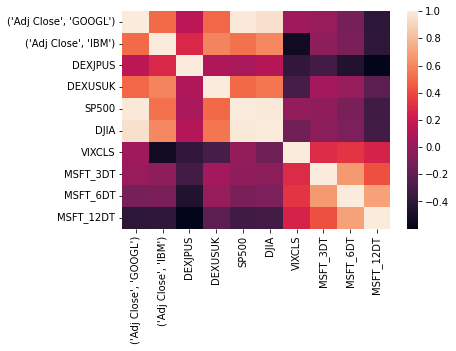

In [559]:
sns.heatmap(X.corr())

In [560]:
lower = pd.DataFrame(np.tril(X.corr(), -1), columns=X.corr().columns)
lower

,"(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.502443,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.142627,0.266252,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.492364,0.592318,0.088711,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.983325,0.522864,0.065211,0.495873,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,0.954155,0.603744,0.110699,0.539900,0.983523,0.000000,0.000000,0.000000,0.000000,0.0
6,0.036919,-0.530827,-0.391689,-0.302625,-0.008897,-0.139544,0.000000,0.000000,0.000000,0.0
7,0.006979,-0.029842,-0.311959,0.050360,-0.023139,-0.039864,0.282019,0.000000,0.000000,0.0
8,-0.115311,-0.093508,-0.461014,0.003517,-0.095613,-0.087408,0.323937,0.664654,0.000000,0.0
9,-0.407278,-0.402191,-0.598947,-0.211769,-0.325111,-0.314147,0.249140,0.413734,0.696994,0.0


<AxesSubplot:>

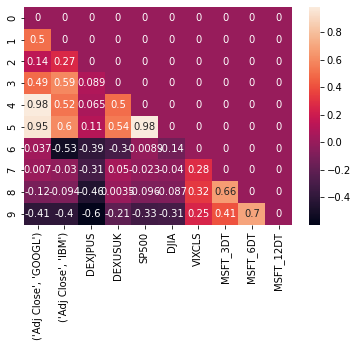

In [561]:
sns.heatmap(lower, annot=True)

In [562]:
to_drop = [column for column in lower if any(lower[column] > 0.9)]
to_drop

[('Adj Close', 'GOOGL'), 'SP500']

In [563]:
X.drop(to_drop, inplace=True, axis=1)
X

,"(Adj Close, IBM)",DEXJPUS,DEXUSUK,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
0,-0.336171,0.004572,0.199625,-1.421847,-1.220836,0.115510,0.092672,-0.257356
1,-0.397327,0.028951,0.191501,-1.411518,-1.247359,0.073382,0.040721,-0.261280
2,-0.438327,0.032608,0.133005,-1.419319,-1.240440,0.151489,0.023393,-0.242482
3,-0.433464,-0.021025,0.344241,-1.411804,-1.275035,0.106757,0.098467,-0.277571
4,-0.452227,-0.047842,0.313368,-1.390946,-1.240440,0.068906,0.144406,-0.262946
...,...,...,...,...,...,...,...,...
1056,1.219405,0.320276,0.984450,1.871663,-0.351346,-1.355163,-2.824533,-3.192499
1057,1.323413,0.237389,1.026697,1.828426,-0.041144,-0.670310,-2.326679,-2.602644
1058,1.274520,0.216667,0.938953,1.779044,-0.170299,-0.697819,-2.426258,-2.525516
1059,1.161623,0.303211,0.805711,1.646091,0.244842,-0.531027,-1.988078,-2.308140


In [564]:
seed = 50

# Option #1
Test_size = int(np.floor(0.3 * len(X)))
train_size = int(np.floor(0.7 * len(X)))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

# Option #2
# X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.3, random_state=seed)

 ## Prepare Parameter Dictionary and Linear Regression(), SVR()

#### (a) Create Model List and Parameter Dictionary

In [565]:
# Create Model List
regression = { 'LR': LinearRegression(), 'SVR': SVR(), }

In [566]:
# Create Parameter Dictionary for Linear Regression
fit_intercept = [True, False]
normalize = [True, False]
params_LR = dict( fit_intercept = fit_intercept, normalize = normalize)


In [567]:
# Create Parameter Dictionary for SVR
kernel = ['linear', 'rbf', 'poly']
C_list = [10, 100]
ep_list = [0.1, 1, 5]
gamma = [0.01, 0.1] 
degree = [2, 3]

params_SVR = dict( kernel = kernel, C = C_list, epsilon = ep_list, gamma = gamma, degree = degree )

#### GridSearchCV() -> (a)

In [568]:
for EST in regression:
    model = regression[EST]
    if (EST == 'LR'):
        params = params_LR
    else:
        params = params_SVR    
    grid = GridSearchCV(estimator=model, 
                        n_jobs = 1,
                        verbose = 10,
                        cv = 4,
                        scoring = 'neg_mean_squared_error',
                        param_grid = params )
    grid_result = grid.fit(X_train, Y_train)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4; 1/4] START fit_intercept=True, normalize=True..........................
[CV 1/4; 1/4] END fit_intercept=True, normalize=True;, score=-534.384 total time=   0.0s
[CV 2/4; 1/4] START fit_intercept=True, normalize=True..........................
[CV 2/4; 1/4] END fit_intercept=True, normalize=True;, score=-808.010 total time=   0.0s
[CV 3/4; 1/4] START fit_intercept=True, normalize=True..........................
[CV 3/4; 1/4] END fit_intercept=True, normalize=True;, score=-1626.168 total time=   0.0s
[CV 4/4; 1/4] START fit_intercept=True, normalize=True..........................
[CV 4/4; 1/4] END fit_intercept=True, normalize=True;, score=-3101.402 total time=   0.0s
[CV 1/4; 2/4] START fit_intercept=True, normalize=False.........................
[CV 1/4; 2/4] END fit_intercept=True, normalize=False;, score=-534.384 total time=   0.0s
[CV 2/4; 2/4] START fit_intercept=True, normalize=False.........................
[CV 2/

#### GridSearchCV() -> (b)

In [569]:
# Show Best Parameters for both models
print('Best params: ',grid_result.best_params_)
print('Best score: ', grid_result.best_score_)

Best params:  {'C': 100, 'degree': 2, 'epsilon': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best score:  -1280.0366982681471


In [570]:
# Show Score for each parameter combination for both model
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
data_zipped = zip(means, stds, params)

# for mean, stdev, param in data_zipped:
  # print("%f (%f) with: %r" % (mean, stdev, param))

data_linear = [{'means': means[i], 'stds': stds[i]} for i in range(len(params)) if params[i]['kernel'] == 'linear' ]
data_rbf = [{'means': means[i], 'stds': stds[i]} for i in range(len(params)) if params[i]['kernel'] == 'rbf' ]
data_poly = [{'means': means[i], 'stds': stds[i]} for i in range(len(params)) if params[i]['kernel'] == 'poly' ]


<AxesSubplot:>

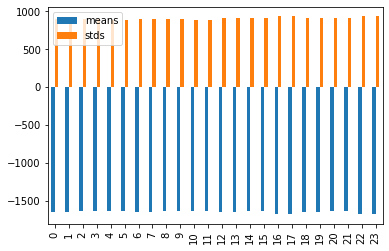

In [571]:
df_linear = pd.DataFrame(data=data_linear)
df_linear.plot.bar()

<AxesSubplot:>

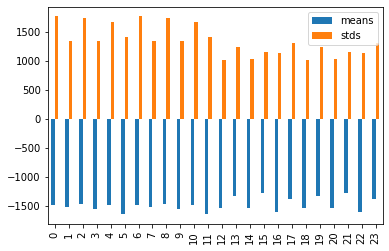

In [572]:
df_rbf = pd.DataFrame(data=data_rbf)
df_rbf.plot.bar()

<AxesSubplot:>

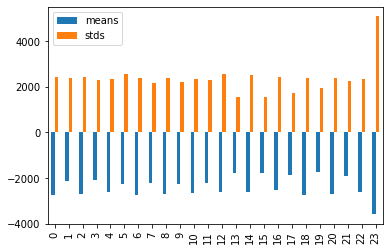

In [573]:
df_poly = pd.DataFrame(data=data_poly)
df_poly.plot.bar()

## 6.3 Prepare Parameter Dicionary and LinearRegression(), SVR()

#### (a) Create Model List and Parameter Dictionary

In [574]:
# Create Model List
regression = { 'LR': LinearRegression(), 'SVR': SVR(), }

In [575]:
# Create Parameter Dictionary for Linear Regression
fit_intercept = [True, False]
normalize = [True, False]
params_LR = dict( fit_intercept = fit_intercept, normalize = normalize)

In [576]:
# Create Parameter Dictionary for SVR
kernel = ['linear', 'rbf', 'poly']
C_list = list(np.linspace(0.1, 150, 5, dtype = float))
ep_list = list(np.linspace(0.1, 1, 5, dtype = float))
gamma = list(np.linspace(0.01, 0.1, 5, dtype = float))
degree = [2, 3]

params_SVR = dict( kernel = kernel, C = C_list, epsilon = ep_list, gamma = gamma, degree = degree )


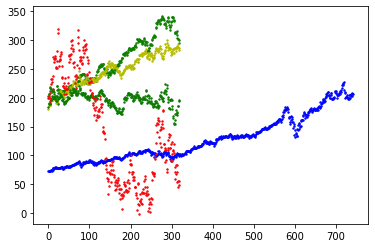

In [577]:
# Scatter plot
c_val = 100
svr_lin = SVR(kernel='linear', C=c_val)
svr_rbf = SVR(kernel='rbf', C=c_val, gamma=0.01)
svr_poly = SVR(kernel='poly', C=c_val, degree=2)

SVR_Linear = svr_lin.fit(X_train,Y_train).predict(X_test)
SVR_Rbf = svr_rbf.fit(X_train,Y_train).predict(X_test)
SVR_Poly = svr_poly.fit(X_train,Y_train).predict(X_test)

plt.scatter(np.arange(len(Y_train)),Y_train, edgecolors='b', s=2)
plt.scatter(np.arange(len(Y_test)),Y_test, edgecolors='g', s=2)
plt.scatter(np.arange(len(SVR_Linear)),SVR_Linear, edgecolors='y', s=2)
plt.scatter(np.arange(len(SVR_Rbf)),SVR_Rbf, edgecolors='g', s=2)
plt.scatter(np.arange(len(SVR_Poly)),SVR_Poly, edgecolors='r', s=2)
plt.show()

#### RandomizedSearchCV() -> (a) 

In [578]:
for EST in regression:
    model = regression[EST]
    if (EST == 'LR'):
        params = params_LR
    else:
        params = params_SVR
    grid_rand = RandomizedSearchCV( estimator=model, n_jobs = 1, 
                                    verbose = 10,
                                    cv = 4,
                                    scoring = 'neg_mean_squared_error',
                                    param_distributions = params )
    grid_rand_result = grid_rand.fit(X_train, Y_train)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4; 1/4] START fit_intercept=True, normalize=True..........................
[CV 1/4; 1/4] END fit_intercept=True, normalize=True;, score=-534.384 total time=   0.0s
[CV 2/4; 1/4] START fit_intercept=True, normalize=True..........................
[CV 2/4; 1/4] END fit_intercept=True, normalize=True;, score=-808.010 total time=   0.0s
[CV 3/4; 1/4] START fit_intercept=True, normalize=True..........................
[CV 3/4; 1/4] END fit_intercept=True, normalize=True;, score=-1626.168 total time=   0.0s
[CV 4/4; 1/4] START fit_intercept=True, normalize=True..........................
[CV 4/4; 1/4] END fit_intercept=True, normalize=True;, score=-3101.402 total time=   0.0s
[CV 1/4; 2/4] START fit_intercept=True, normalize=False.........................
[CV 1/4; 2/4] END fit_intercept=True, normalize=False;, score=-534.384 total time=   0.0s
[CV 2/4; 2/4] START fit_intercept=True, normalize=False.........................
[CV 2/

#### RandomizedCV() -> (b)

In [579]:
# Show Best Parameters for both models
print('Best params: ',grid_rand_result.best_params_)
print('Best score: ', grid_rand_result.best_score_)

Best params:  {'kernel': 'rbf', 'gamma': 0.05500000000000001, 'epsilon': 0.325, 'degree': 3, 'C': 112.525}
Best score:  -1200.5179071275438


In [580]:
# Show Score for each parameter combination for both model
means = grid_rand_result.cv_results_['mean_test_score']
stds = grid_rand_result.cv_results_['std_test_score']
params = grid_rand_result.cv_results_['params']
data_zipped = zip(means, stds, params)

# for mean, stdev, param in data_zipped:
    # print("%f (%f) with: %r" % (mean, stdev, param))

data_linear = [{'means': means[i], 'stds': stds[i]} for i in range(len(params)) if params[i]['kernel'] == 'linear' ]
data_rbf = [{'means': means[i], 'stds': stds[i]} for i in range(len(params)) if params[i]['kernel'] == 'rbf' ]
data_poly = [{'means': means[i], 'stds': stds[i]} for i in range(len(params)) if params[i]['kernel'] == 'poly' ]
data_merged = data_linear + data_rbf + data_poly

<AxesSubplot:>

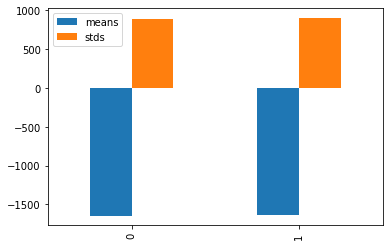

In [581]:
df_linear = pd.DataFrame(data=data_linear)
df_linear.plot.bar()

<AxesSubplot:>

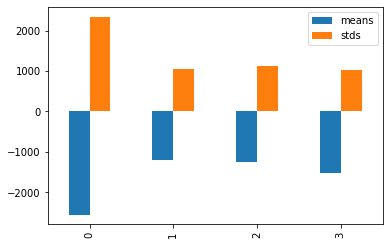

In [582]:
df_rbf = pd.DataFrame(data=data_rbf)
df_rbf.plot.bar()

<AxesSubplot:>

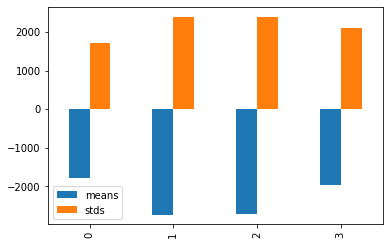

In [583]:
df_poly = pd.DataFrame(data=data_poly)
df_poly.plot.bar()

<AxesSubplot:>

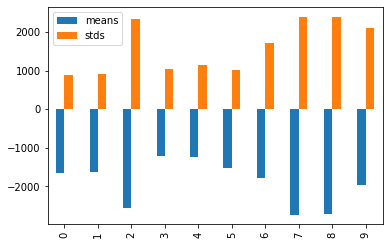

In [584]:
df_poly = pd.DataFrame(data=data_merged)
df_poly.plot.bar()